In [1]:
import re
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import *
from sklearn.preprocessing import StandardScaler
import math
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm 
import seaborn as sns
import pylab as py 
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from sklearn.datasets import load_boston

boston = load_boston()

print(boston.keys())
print(boston.data.shape)
print(boston.target.shape)
print(boston.feature_names)

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])
(506, 13)
(506,)
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [3]:
boston_df = pd.DataFrame(boston.data)
boston_df.columns = boston.feature_names
boston_df['price'] = boston.target
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [4]:
boston_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,price
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


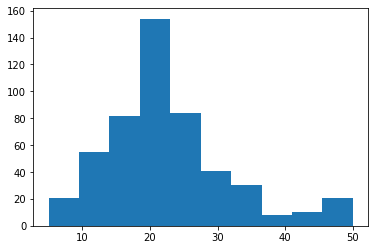

In [5]:
# visualizing the distribution of "price"

boston_df['price'].hist()
plt.grid(False)
plt.show()

In [21]:
def standarise(df,column,pct,pct_lower):
    sc = StandardScaler() 
    y = df[column][df[column].notnull()].to_list()
    y.sort()
    len_y = len(y)
    y = y[int(pct_lower * len_y):int(len_y * pct)]
    len_y = len(y)
    yy=([[x] for x in y])
    sc.fit(yy)
    y_std =sc.transform(yy)
    y_std = y_std.flatten()
    return y_std,len_y,y

In [28]:
def fit_distribution(df,column,pct,pct_lower):
    # See list of all available distributions here:
    # https://docs.scipy.org/doc/scipy/reference/stats.html
    y_std,size,y_org = standarise(df,column,pct,pct_lower)
    dist_names = ['weibull_min','norm','weibull_max','beta',
                 'invgauss','uniform','gamma','expon', 'lognorm','pearson3','triang']

    chi_square_statistics = []
    # 11 bins
    percentile_bins = np.linspace(0,100,11)
    percentile_cutoffs = np.percentile(y_std, percentile_bins)
    observed_frequency, bins = (np.histogram(y_std, bins=percentile_cutoffs))
    cum_observed_frequency = np.cumsum(observed_frequency)

    # Loop through candidate distributions
    for distribution in dist_names:
        # Set up distribution and get fitted distribution parameters
        dist = getattr(scipy.stats, distribution)
        param = dist.fit(y_std)
        print("{}\n{}\n".format(dist, param))
      

        # Get expected counts in percentile bins
        # cdf of fitted distribution across bins
        cdf_fitted = dist.cdf(percentile_cutoffs, *param)
        expected_frequency = []
        for bin in range(len(percentile_bins)-1):
            expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
            expected_frequency.append(expected_cdf_area)

        # Chi-square Statistics
        expected_frequency = np.array(expected_frequency) * size
        cum_expected_frequency = np.cumsum(expected_frequency)
        ss = round(sum (((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency),0)
        chi_square_statistics.append(ss)


    #Sort by minimum ch-square statistics
    results = pd.DataFrame()
    results['Distribution'] = dist_names
    results['chi_square'] = chi_square_statistics
    results.sort_values(['chi_square'], inplace=True)


    print ('\nDistributions listed by Betterment of fit:')
    print ('.'*40)
    print (results)

In [29]:
fit_distribution(boston_df, 'price', 0.99, 0.01) # chopping off the edges to bring smoothness to distribution, by trimming from 99th percentils and 1st percentil

(0.978878952298197, -1.7832146640728337, 1.3883473512178457)

(-2.2967037923558794e-16, 0.9999999999999999)

(76.18181610803504, 59.50168876199268, 59.94454104923045)

(4.80004987782203, 2410896.424119925, -2.1802248676330174, 1097063.6094508418)

(0.10046194879683529, -3.107343032945483, 30.930544962095276)

(-1.7832146640728335, 4.989119461176211)

(5.252334021314914, -2.2490593075038543, 0.42820134675305327)

(-1.7832146640728335, 1.7832146640728332)

(0.31927336237428616, -3.0169095372473556, 2.8661859807496777)

(0.8726643169247601, -2.519820166239276e-16, 0.9813789880986407)

(0.23831279767760183, -1.9292374417120741, 5.335314751544187)


Distributions listed by Betterment of fit:
........................................
   Distribution  chi_square
2   weibull_max         9.0
8       lognorm        10.0
4      invgauss        11.0
6         gamma        12.0
9      pearson3        12.0
3          beta        14.0
1          norm        51.0
10       triang        66.0
5       uni

In [30]:
y_std,len_y,y = standarise(boston_df,'price',0.99,0.01)

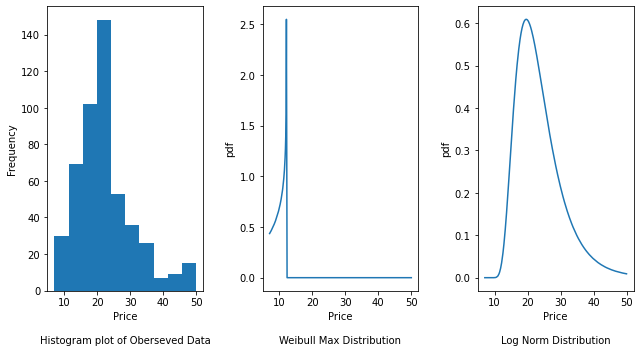

In [84]:
# because 'weibull_max', 'lognorm', 'invgauss', 'gamma', 'pearson3' seem to fit good to the actual data distribution
# let use also visually confirm the same

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 5))
axes[0].hist(y)
axes[0].set_xlabel('Price\n\nHistogram plot of Oberseved Data')
axes[0].set_ylabel('Frequency')
axes[1].plot(y, weibull_max.pdf(y_std, 0.8, -1.19, 1.19))
axes[1].set_xlabel('Price\n\nWeibull Max Distribution')
axes[1].set_ylabel('pdf')
axes[2].plot(y, lognorm.pdf(y_std,0.45, -1.64, 1.61))
axes[2].set_xlabel('Price\n\nLog Norm Distribution')
axes[2].set_ylabel('pdf')
fig.tight_layout()

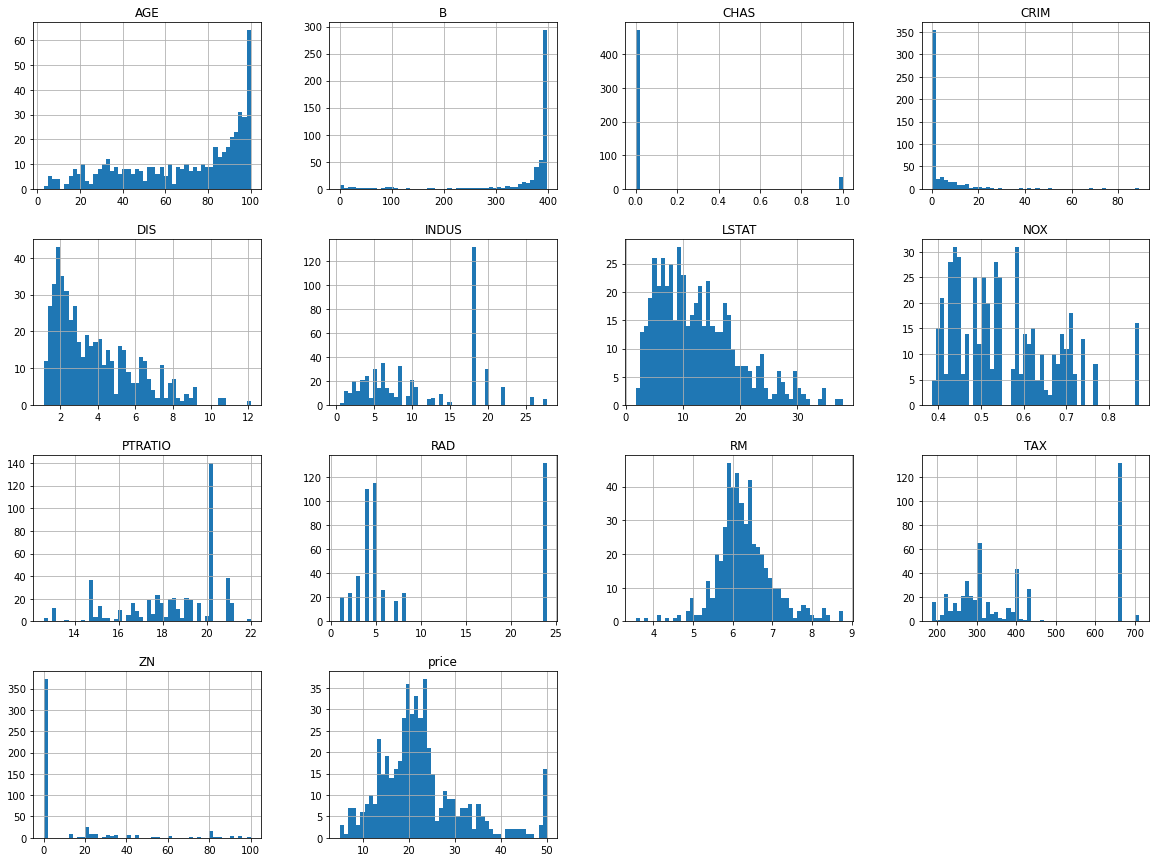

In [7]:
# a quick look at the overall distribution of all numerical attributes
boston_df.hist(bins=50, figsize=(20,15))
plt.show()

In [8]:
# trying different distributions and checking for their p-values
def get_distribution(data):
    size = len(data)
    
    # can add more distributions from here: https://docs.scipy.org/doc/scipy/reference/stats.html
    dist_names = ['norm', 'beta', 'lognorm', 'expon', 'pearson3', 'uniform', 'weibull_min', 'weibull_max']
    
    # reshaping for scaling & scaling for KS test
    sc = StandardScaler().fit(data.reshape(-1,1))
    
    dist_results = []
    for dist_name in dist_names:
        dist = getattr(scipy.stats, dist_name)
        param = dist.fit(data)
        pdf_fitted = dist.pdf(data, *param[:-2], loc=param[-2], scale=param[-1]) * size
        
        # applying KS-test (Kolmogorov-Smirnov)
        _, p = scipy.stats.kstest(sc.transform(data.reshape(-1,1)), dist_name, args=param)
        print('p-value for {} distribution = {}'.format(dist_name, p))
        dist_results.append((dist_name, p))
        
        plt.plot(pdf_fitted, label=dist_name)
        plt.xlim(0,52)
    plt.legend(loc='upper right')
    plt.show()
    
    # finding the best fitting distribution
    best_dist, best_p_val = (max(dist_results, key=lambda x: x[1]))
    print('Best fitting distribution: {} with p-value = {}'.format(best_dist, best_p_val))
    print()


-----------------------------------
Fitting distributions across CRIM
-----------------------------------
p-value for norm distribution = 2.307621441e-314
p-value for beta distribution = 0.0
p-value for lognorm distribution = 0.0
p-value for expon distribution = 0.0
p-value for pearson3 distribution = nan
p-value for uniform distribution = 0.0
p-value for weibull_min distribution = 0.0
p-value for weibull_max distribution = 0.0


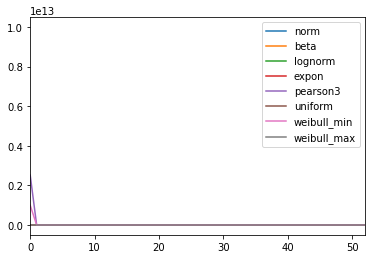

Best fitting distribution: norm with p-value = 2.307621441e-314

-----------------------------------
Fitting distributions across ZN
-----------------------------------
p-value for norm distribution = 2.0933200032431785e-244
p-value for beta distribution = 0.0
p-value for lognorm distribution = 0.0
p-value for expon distribution = 0.0
p-value for pearson3 distribution = nan
p-value for uniform distribution = 0.0
p-value for weibull_min distribution = 0.0
p-value for weibull_max distribution = 0.0


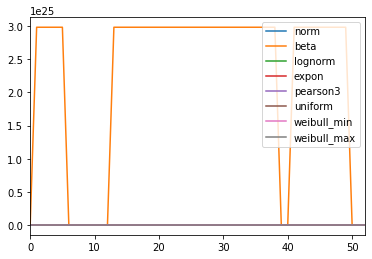

Best fitting distribution: norm with p-value = 2.0933200032431785e-244

-----------------------------------
Fitting distributions across INDUS
-----------------------------------
p-value for norm distribution = 0.0
p-value for beta distribution = 0.0
p-value for lognorm distribution = 0.0
p-value for expon distribution = 0.0
p-value for pearson3 distribution = nan
p-value for uniform distribution = 0.0
p-value for weibull_min distribution = 0.0
p-value for weibull_max distribution = 0.0


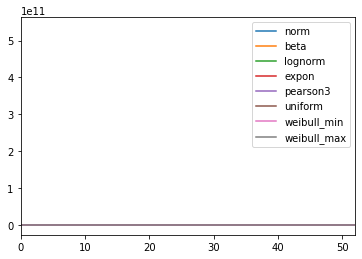

Best fitting distribution: norm with p-value = 0.0

-----------------------------------
Fitting distributions across CHAS
-----------------------------------
p-value for norm distribution = 0.0
p-value for beta distribution = 0.0
p-value for lognorm distribution = 0.0
p-value for expon distribution = 0.0
p-value for pearson3 distribution = nan
p-value for uniform distribution = 0.0
p-value for weibull_min distribution = 0.0
p-value for weibull_max distribution = 0.0


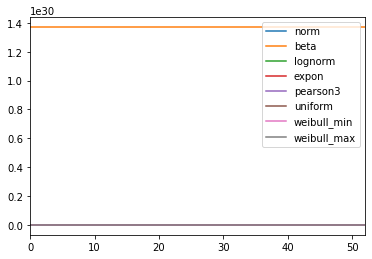

Best fitting distribution: norm with p-value = 0.0

-----------------------------------
Fitting distributions across NOX
-----------------------------------
p-value for norm distribution = 0.0
p-value for beta distribution = 0.0
p-value for lognorm distribution = 0.0
p-value for expon distribution = 0.0
p-value for pearson3 distribution = nan
p-value for uniform distribution = 0.0
p-value for weibull_min distribution = 0.0
p-value for weibull_max distribution = 0.0


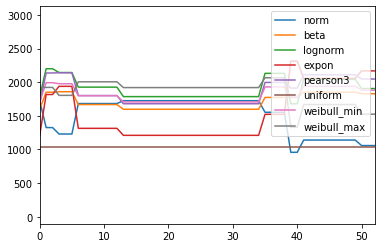

Best fitting distribution: norm with p-value = 0.0

-----------------------------------
Fitting distributions across RM
-----------------------------------
p-value for norm distribution = 0.0
p-value for beta distribution = 0.0
p-value for lognorm distribution = 0.0
p-value for expon distribution = 0.0
p-value for pearson3 distribution = nan
p-value for uniform distribution = 0.0
p-value for weibull_min distribution = 0.0
p-value for weibull_max distribution = 0.0


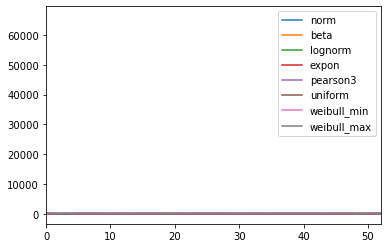

Best fitting distribution: norm with p-value = 0.0

-----------------------------------
Fitting distributions across AGE
-----------------------------------
p-value for norm distribution = 0.0
p-value for beta distribution = 0.0
p-value for lognorm distribution = 0.0
p-value for expon distribution = 0.0
p-value for pearson3 distribution = 0.0
p-value for uniform distribution = 0.0
p-value for weibull_min distribution = 0.0
p-value for weibull_max distribution = 0.0


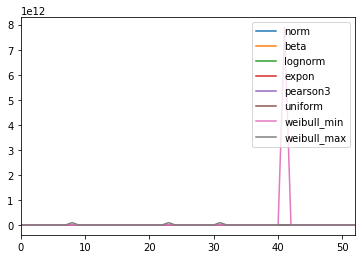

Best fitting distribution: norm with p-value = 0.0

-----------------------------------
Fitting distributions across DIS
-----------------------------------
p-value for norm distribution = 0.0
p-value for beta distribution = 0.0
p-value for lognorm distribution = 0.0
p-value for expon distribution = 0.0
p-value for pearson3 distribution = nan
p-value for uniform distribution = 0.0
p-value for weibull_min distribution = 0.0
p-value for weibull_max distribution = 0.0


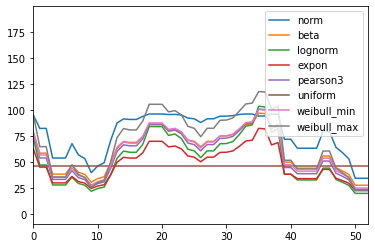

Best fitting distribution: norm with p-value = 0.0

-----------------------------------
Fitting distributions across RAD
-----------------------------------
p-value for norm distribution = 0.0
p-value for beta distribution = 4.439569490255713e-216
p-value for lognorm distribution = 0.0
p-value for expon distribution = 0.0
p-value for pearson3 distribution = nan
p-value for uniform distribution = 0.0
p-value for weibull_min distribution = 0.0
p-value for weibull_max distribution = 0.0


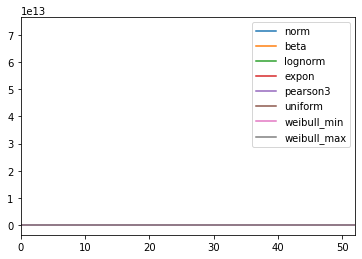

Best fitting distribution: beta with p-value = 4.439569490255713e-216

-----------------------------------
Fitting distributions across TAX
-----------------------------------
p-value for norm distribution = 0.0
p-value for beta distribution = 0.0
p-value for lognorm distribution = 0.0
p-value for expon distribution = 0.0
p-value for pearson3 distribution = nan
p-value for uniform distribution = 0.0
p-value for weibull_min distribution = 0.0
p-value for weibull_max distribution = 0.0


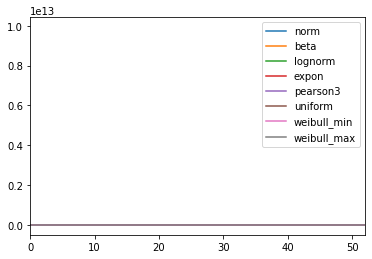

Best fitting distribution: norm with p-value = 0.0

-----------------------------------
Fitting distributions across PTRATIO
-----------------------------------
p-value for norm distribution = 0.0
p-value for beta distribution = 0.0
p-value for lognorm distribution = 0.0
p-value for expon distribution = 0.0
p-value for pearson3 distribution = 0.0
p-value for uniform distribution = 0.0
p-value for weibull_min distribution = 0.0
p-value for weibull_max distribution = 0.0


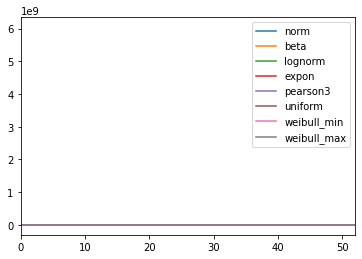

Best fitting distribution: norm with p-value = 0.0

-----------------------------------
Fitting distributions across B
-----------------------------------
p-value for norm distribution = 0.0
p-value for beta distribution = 0.0
p-value for lognorm distribution = 0.0
p-value for expon distribution = 0.0
p-value for pearson3 distribution = 0.0
p-value for uniform distribution = 0.0
p-value for weibull_min distribution = 0.0
p-value for weibull_max distribution = 0.0


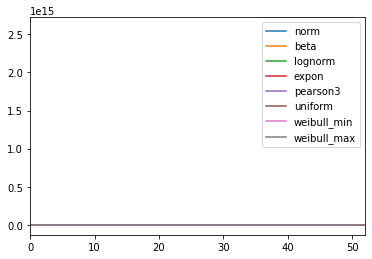

Best fitting distribution: norm with p-value = 0.0

-----------------------------------
Fitting distributions across LSTAT
-----------------------------------
p-value for norm distribution = 0.0
p-value for beta distribution = 0.0
p-value for lognorm distribution = 0.0
p-value for expon distribution = 0.0
p-value for pearson3 distribution = nan
p-value for uniform distribution = 0.0
p-value for weibull_min distribution = 0.0
p-value for weibull_max distribution = 0.0


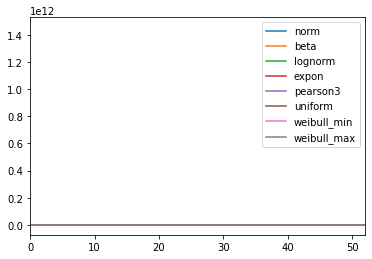

Best fitting distribution: norm with p-value = 0.0

-----------------------------------
Fitting distributions across price
-----------------------------------
p-value for norm distribution = 0.0
p-value for beta distribution = 0.0
p-value for lognorm distribution = 0.0
p-value for expon distribution = 0.0
p-value for pearson3 distribution = nan
p-value for uniform distribution = 0.0
p-value for weibull_min distribution = 0.0
p-value for weibull_max distribution = 0.0


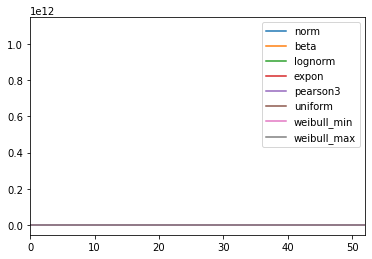

Best fitting distribution: norm with p-value = 0.0



In [9]:
# run the distribution assesment for all columns in pandas
for col in boston_df.columns:
    print('-'*35)
    print('Fitting distributions across {}'.format(col))
    print('-'*35)
    
    get_distribution(boston_df[col].values)